# PETSc performance breakdown

This notebook runs timing breakdown using PETSc events:

- Warmup + timed solve per approach and mesh size
- Event times: SNESSolve, KSPSolve, PCSetUp, PCApply, Jacobian/Residual evals, MatAssembly
- Outputs a CSV of results

You can tweak the mesh sizes and approaches as needed.

Highly inspired by this work: https://github.com/thomasgibson/tabula-rasa

In [1]:
import os

os.environ["OMP_NUM_THREADS"] = "1"

from typing import List
import matplotlib.pyplot as plt

from perphil.experiments.iterative_bench import Approach
from perphil.experiments.petsc_profiling import run_perf_sweep, save_perf_csv

## Parameters

In [2]:
mesh_sizes: List[int] = [8, 16, 32, 64]
approaches: List[Approach] = [
    Approach.PLAIN_GMRES,
    Approach.GMRES_ILU,
    # Approach.SS_GMRES,
    # Approach.SS_GMRES_ILU,
    # Approach.PICARD_MUMPS,
    # Approach.MONOLITHIC_MUMPS,
]
extra_events: List[str] = []

## Run and collect

In [3]:
df = run_perf_sweep(mesh_sizes, approaches, repeats=7, backend="events")
df.sort_values(["nx", "approach"])

[perf] nx=8 GMRES: iters=16, KSPSolve=8.155e-04s, PCApply=3.660e-05s, flops_total=6.162e+06 (backend=events, repeats=7)
[perf] nx=8 GMRES + ILU PC: iters=8, KSPSolve=1.934e-03s, PCApply=5.208e-04s, flops_total=6.876e+06 (backend=events, repeats=7)
[perf] nx=16 GMRES: iters=39, KSPSolve=4.611e-03s, PCApply=1.182e-04s, flops_total=4.631e+07 (backend=events, repeats=7)
[perf] nx=16 GMRES + ILU PC: iters=14, KSPSolve=3.499e-03s, PCApply=2.042e-03s, flops_total=3.815e+07 (backend=events, repeats=7)
[perf] nx=32 GMRES: iters=139, KSPSolve=5.284e-02s, PCApply=1.141e-03s, flops_total=5.417e+08 (backend=events, repeats=7)
[perf] nx=32 GMRES + ILU PC: iters=24, KSPSolve=2.811e-02s, PCApply=1.670e-02s, flops_total=2.271e+08 (backend=events, repeats=7)
[perf] nx=64 GMRES: iters=422, KSPSolve=8.412e-01s, PCApply=1.954e-02s, flops_total=6.195e+09 (backend=events, repeats=7)
[perf] nx=64 GMRES + ILU PC: iters=49, KSPSolve=2.721e-01s, PCApply=1.626e-01s, flops_total=1.585e+09 (backend=events, repeats=

,approach,nx,ny,dofs,num_cells,iterations,residual,metadata,time_MatMult,time_SNESJacobianEval,...,mflops_SNESFunctionEval,flops_KSPSolve,mflops_KSPSolve,flops_MatAssemblyBegin,mflops_MatAssemblyBegin,flops_PCSetUp,mflops_PCSetUp,flops_PCApply,mflops_PCApply,flops_total
0,GMRES,8,8,162,64,16,5.200343e-12,"{'petsc_version': (3, 23, 3), 'firedrake_versi...",0.000192,0.028893,...,18.627305,1.254071e+06,1537.793991,0.0,0.0,0.0,0.000000,0.0,0.000000,6.161610e+06
1,GMRES + ILU PC,8,8,162,64,8,5.206056e-12,"{'petsc_version': (3, 23, 3), 'firedrake_versi...",0.000198,0.041728,...,13.082270,1.080037e+06,558.476136,0.0,0.0,369271.0,159.216574,595098.0,1142.661290,6.876254e+06
2,GMRES,16,16,578,256,39,7.016859e-12,"{'petsc_version': (3, 23, 3), 'firedrake_versi...",0.002177,0.036885,...,53.888225,1.430390e+07,3102.193715,0.0,0.0,0.0,0.000000,0.0,0.000000,4.630664e+07
3,GMRES + ILU PC,16,16,578,256,14,1.401697e-12,"{'petsc_version': (3, 23, 3), 'firedrake_versi...",0.000658,0.037352,...,55.291881,7.826700e+06,2236.583414,0.0,0.0,2096647.0,414.463597,3999030.0,1958.101160,3.815389e+07
4,GMRES,32,32,2178,1024,139,8.144140e-12,"{'petsc_version': (3, 23, 3), 'firedrake_versi...",0.032593,0.052306,...,190.292164,2.092680e+08,3960.641597,0.0,0.0,0.0,0.000000,0.0,0.000000,5.417109e+08
5,GMRES + ILU PC,32,32,2178,1024,24,9.450213e-12,"{'petsc_version': (3, 23, 3), 'firedrake_versi...",0.006014,0.048395,...,218.511008,5.924752e+07,2107.919956,0.0,0.0,9790375.0,522.565812,26769050.0,1603.205927,2.271324e+08
6,GMRES,64,64,8450,4096,422,1.548317e-11,"{'petsc_version': (3, 23, 3), 'firedrake_versi...",0.515977,0.095136,...,706.466353,2.555508e+09,3037.919954,0.0,0.0,0.0,0.000000,0.0,0.000000,6.194892e+09
7,GMRES + ILU PC,64,64,8450,4096,49,1.180410e-11,"{'petsc_version': (3, 23, 3), 'firedrake_versi...",0.068429,0.079273,...,821.925774,4.903953e+08,1802.219544,0.0,0.0,42133735.0,621.302239,218885982.0,1346.087752,1.585477e+09


## Save CSV (optional)

In [4]:
save_perf_csv(df, "results/petsc_perf_breakdown.csv")
df.head()

,approach,nx,ny,dofs,num_cells,iterations,residual,metadata,time_MatMult,time_SNESJacobianEval,...,mflops_SNESFunctionEval,flops_KSPSolve,mflops_KSPSolve,flops_MatAssemblyBegin,mflops_MatAssemblyBegin,flops_PCSetUp,mflops_PCSetUp,flops_PCApply,mflops_PCApply,flops_total
0,GMRES,8,8,162,64,16,5.200343e-12,"{'petsc_version': (3, 23, 3), 'firedrake_versi...",0.000192,0.028893,...,18.627305,1254071.0,1537.793991,0.0,0.0,0.0,0.000000,0.0,0.00000,6161610.0
1,GMRES + ILU PC,8,8,162,64,8,5.206056e-12,"{'petsc_version': (3, 23, 3), 'firedrake_versi...",0.000198,0.041728,...,13.082270,1080037.0,558.476136,0.0,0.0,369271.0,159.216574,595098.0,1142.66129,6876254.0
2,GMRES,16,16,578,256,39,7.016859e-12,"{'petsc_version': (3, 23, 3), 'firedrake_versi...",0.002177,0.036885,...,53.888225,14303905.0,3102.193715,0.0,0.0,0.0,0.000000,0.0,0.00000,46306638.0
3,GMRES + ILU PC,16,16,578,256,14,1.401697e-12,"{'petsc_version': (3, 23, 3), 'firedrake_versi...",0.000658,0.037352,...,55.291881,7826700.0,2236.583414,0.0,0.0,2096647.0,414.463597,3999030.0,1958.10116,38153892.0
4,GMRES,32,32,2178,1024,139,8.144140e-12,"{'petsc_version': (3, 23, 3), 'firedrake_versi...",0.032593,0.052306,...,190.292164,209268024.0,3960.641597,0.0,0.0,0.0,0.000000,0.0,0.00000,541710946.0


## Plot: KSPSolve and PCApply share

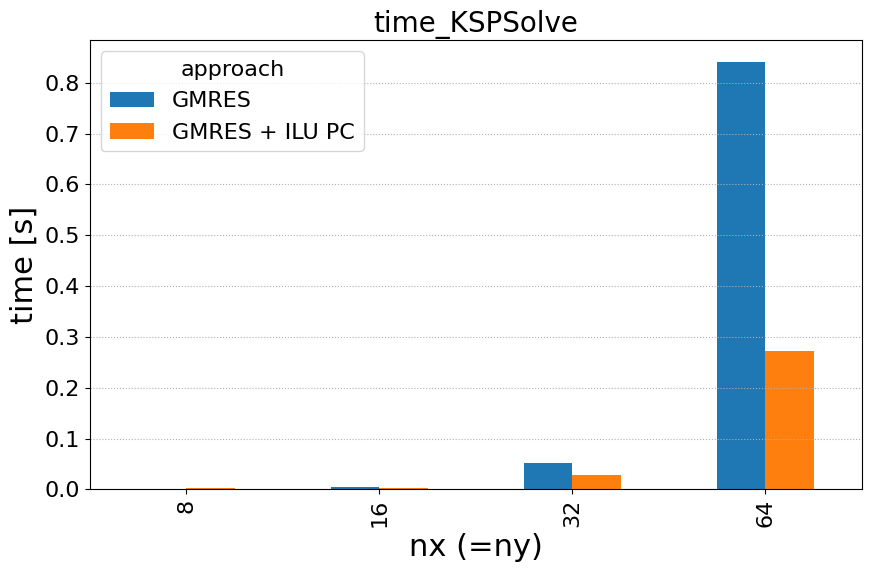

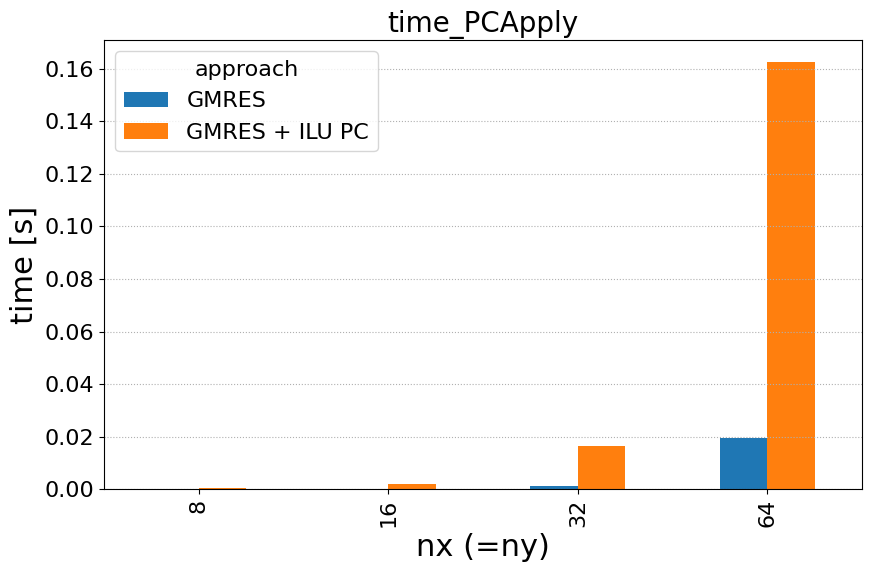

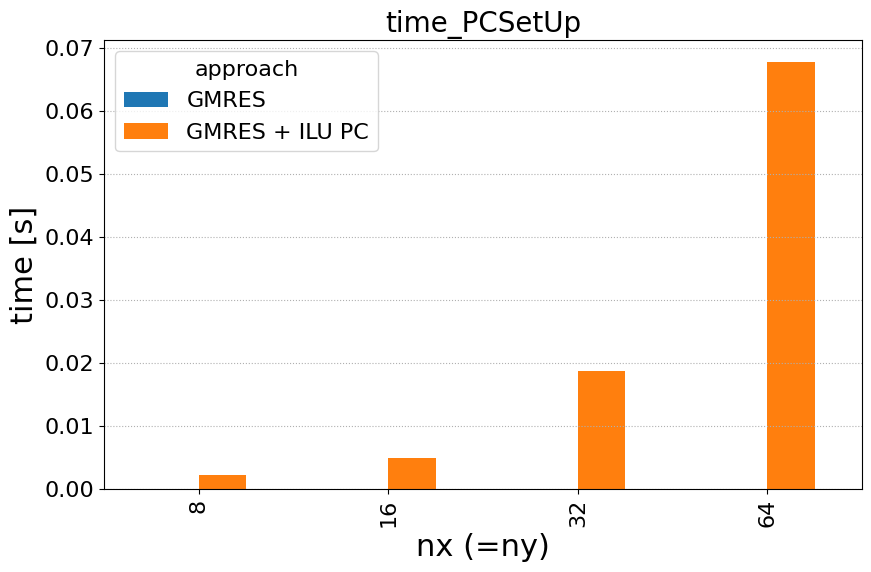

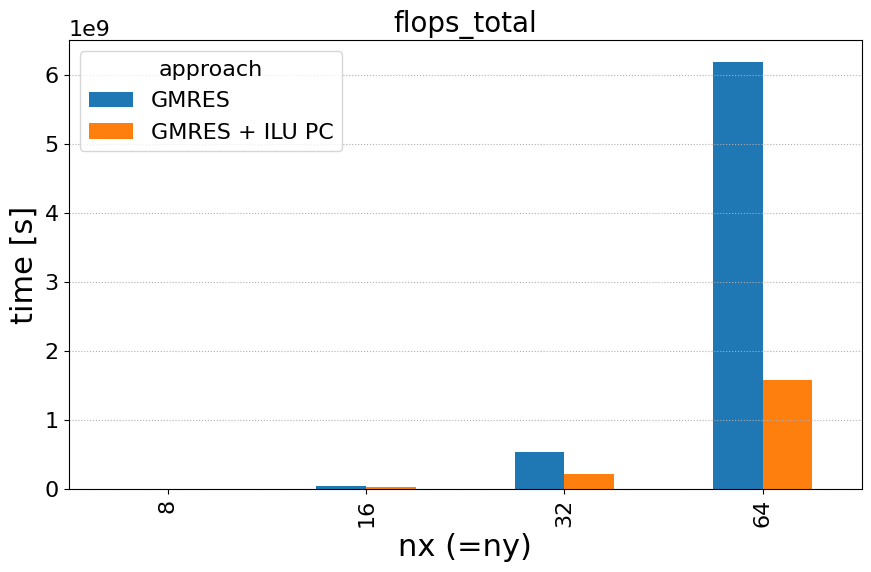

In [5]:
for metric in ("time_KSPSolve", "time_PCApply", "time_PCSetUp", "flops_total"):
    pivot = df.pivot(index="nx", columns="approach", values=metric).sort_index()
    ax = pivot.plot(kind="bar", figsize=(9, 6), title=metric)
    ax.set_xlabel("nx (=ny)")
    ax.set_ylabel("time [s]")
    ax.grid(axis="y", ls=":")
    plt.tight_layout()
    plt.show()

In [6]:
df

,approach,nx,ny,dofs,num_cells,iterations,residual,metadata,time_MatMult,time_SNESJacobianEval,...,mflops_SNESFunctionEval,flops_KSPSolve,mflops_KSPSolve,flops_MatAssemblyBegin,mflops_MatAssemblyBegin,flops_PCSetUp,mflops_PCSetUp,flops_PCApply,mflops_PCApply,flops_total
0,GMRES,8,8,162,64,16,5.200343e-12,"{'petsc_version': (3, 23, 3), 'firedrake_versi...",0.000192,0.028893,...,18.627305,1.254071e+06,1537.793991,0.0,0.0,0.0,0.000000,0.0,0.000000,6.161610e+06
1,GMRES + ILU PC,8,8,162,64,8,5.206056e-12,"{'petsc_version': (3, 23, 3), 'firedrake_versi...",0.000198,0.041728,...,13.082270,1.080037e+06,558.476136,0.0,0.0,369271.0,159.216574,595098.0,1142.661290,6.876254e+06
2,GMRES,16,16,578,256,39,7.016859e-12,"{'petsc_version': (3, 23, 3), 'firedrake_versi...",0.002177,0.036885,...,53.888225,1.430390e+07,3102.193715,0.0,0.0,0.0,0.000000,0.0,0.000000,4.630664e+07
3,GMRES + ILU PC,16,16,578,256,14,1.401697e-12,"{'petsc_version': (3, 23, 3), 'firedrake_versi...",0.000658,0.037352,...,55.291881,7.826700e+06,2236.583414,0.0,0.0,2096647.0,414.463597,3999030.0,1958.101160,3.815389e+07
4,GMRES,32,32,2178,1024,139,8.144140e-12,"{'petsc_version': (3, 23, 3), 'firedrake_versi...",0.032593,0.052306,...,190.292164,2.092680e+08,3960.641597,0.0,0.0,0.0,0.000000,0.0,0.000000,5.417109e+08
5,GMRES + ILU PC,32,32,2178,1024,24,9.450213e-12,"{'petsc_version': (3, 23, 3), 'firedrake_versi...",0.006014,0.048395,...,218.511008,5.924752e+07,2107.919956,0.0,0.0,9790375.0,522.565812,26769050.0,1603.205927,2.271324e+08
6,GMRES,64,64,8450,4096,422,1.548317e-11,"{'petsc_version': (3, 23, 3), 'firedrake_versi...",0.515977,0.095136,...,706.466353,2.555508e+09,3037.919954,0.0,0.0,0.0,0.000000,0.0,0.000000,6.194892e+09
7,GMRES + ILU PC,64,64,8450,4096,49,1.180410e-11,"{'petsc_version': (3, 23, 3), 'firedrake_versi...",0.068429,0.079273,...,821.925774,4.903953e+08,1802.219544,0.0,0.0,42133735.0,621.302239,218885982.0,1346.087752,1.585477e+09
